In [10]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


In [11]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [12]:
class CnnNet2(nn.Module):
    def __init__(self):
        super(CnnNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(3200, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [13]:
class CnnNet3(nn.Module):
    def __init__(self):
        super(CnnNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5408, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    

In [5]:
print("model 1 - parameters", sum(p.numel() for p in CnnNet().parameters() if p.requires_grad))
print("model 2 - parameters", sum(p.numel() for p in CnnNet2().parameters() if p.requires_grad))
print("model 3 - parameters", sum(p.numel() for p in CnnNet3().parameters() if p.requires_grad))

model 1 - parameters 1199882
model 2 - parameters 503690
model 3 - parameters 693962


In [17]:

print(CnnNet2())
print(CnnNet3())


CnnNet2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
CnnNet3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
def train( model, device, train_loader, optimizer, loss_fn, epoch):
    train_loss=0
    model.train()
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    print("Training - Epoch:", epoch, "loss:", train_loss, "accuracy:", 100. * correct / len(train_loader.dataset))  
    return train_loss, 100. * correct / len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [22]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 512}
test_kwargs = {'batch_size': 512}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [82]:
def returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler):
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    for epoch in range(1, epoch+1):
        tr_loss, tr_accuracy=train(model, device, train_loader, optimizer, loss, epoch)
        train_loss.append(tr_loss)
        accuracy_train.append(tr_accuracy)
    return train_loss, accuracy_train, test_loss, accuracy_test

In [83]:
epoch=50
model = CnnNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_1, accuracy_train_1, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)


Exception ignored in: Traceback (most recent call last):
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 1 loss: 2.4750497359752655 accuracy: 86.99833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 2 loss: 0.5410235017776489 accuracy: 97.31166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 3 loss: 0.3939771236658096 accuracy: 98.07


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 4 loss: 0.3019796757221222 accuracy: 98.48666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 5 loss: 0.2598894501686096 accuracy: 98.68666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 6 loss: 0.22345287179350853 accuracy: 98.89166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 7 loss: 0.199007037627697 accuracy: 98.98


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 8 loss: 0.17936627624034882 accuracy: 99.08333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 9 loss: 0.16029579362273216 accuracy: 99.16833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 10 loss: 0.1495482782483101 accuracy: 99.18333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 11 loss: 0.13602318971157074 accuracy: 99.27833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 12 loss: 0.12813356602191925 accuracy: 99.35166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 13 loss: 0.12154293861389161 accuracy: 99.34666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 14 loss: 0.115119551217556 accuracy: 99.39


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 15 loss: 0.10928890585899353 accuracy: 99.40166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 16 loss: 0.1018302950322628 accuracy: 99.42


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 17 loss: 0.0928161416053772 accuracy: 99.505


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 18 loss: 0.09725285097360611 accuracy: 99.475


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 19 loss: 0.09595577998608351 accuracy: 99.46166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 20 loss: 0.09673381790071726 accuracy: 99.49166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 21 loss: 0.08837366298437119 accuracy: 99.54333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 22 loss: 0.09617689370810986 accuracy: 99.51166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 23 loss: 0.0927681491367519 accuracy: 99.515


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 24 loss: 0.0972462339937687 accuracy: 99.48666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 25 loss: 0.10931865906715393 accuracy: 99.49333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 26 loss: 0.09798775239447131 accuracy: 99.53333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 27 loss: 0.11067196791358293 accuracy: 99.475


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 28 loss: 0.10245916271209717 accuracy: 99.48166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 29 loss: 0.09407982651889324 accuracy: 99.53666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 30 loss: 0.10098399603366852 accuracy: 99.49166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 31 loss: 0.11393547679483891 accuracy: 99.46166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 32 loss: 0.09870820651948452 accuracy: 99.55666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 33 loss: 0.11770426944196224 accuracy: 99.46333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 34 loss: 0.12572892825603485 accuracy: 99.43833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 35 loss: 0.1039132312476635 accuracy: 99.50333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 36 loss: 0.11921063106656074 accuracy: 99.44833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 37 loss: 0.116128726708889 accuracy: 99.49


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 38 loss: 0.11234292581956834 accuracy: 99.49333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 39 loss: 0.11040897264480591 accuracy: 99.47


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 40 loss: 0.12397385559082032 accuracy: 99.46333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 41 loss: 0.11946155702471734 accuracy: 99.48833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 42 loss: 0.13220113482475282 accuracy: 99.42333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 43 loss: 0.12950997049808502 accuracy: 99.42666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 44 loss: 0.1363686851799488 accuracy: 99.37833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 45 loss: 0.13495048168748616 accuracy: 99.44


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 46 loss: 0.12545081167817115 accuracy: 99.46333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 47 loss: 0.13550016360878944 accuracy: 99.44


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 48 loss: 0.12157946175336838 accuracy: 99.43833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 49 loss: 0.15782207653522493 accuracy: 99.37666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 50 loss: 0.14591497410535811 accuracy: 99.34833333333333


In [84]:
epoch=50
model = CnnNet2().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_2, accuracy_train_2, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 1 loss: 8.287468980026246 accuracy: 56.196666666666665


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 2 loss: 2.41864439163208 accuracy: 87.62


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 3 loss: 1.8982629497528076 accuracy: 90.435


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 4 loss: 1.6842450477600097 accuracy: 91.60166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 5 loss: 1.5512995607376099 accuracy: 92.31333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 6 loss: 1.432454437160492 accuracy: 92.86333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 7 loss: 1.3554800231933595 accuracy: 93.24333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 8 loss: 1.2621295404434205 accuracy: 93.74333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 9 loss: 1.2002530784606933 accuracy: 93.96333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 10 loss: 1.1432482717514039 accuracy: 94.32833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 11 loss: 1.0702635074615479 accuracy: 94.73833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 12 loss: 1.0117741223335266 accuracy: 95.055


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 13 loss: 0.9825166798591614 accuracy: 95.1


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 14 loss: 0.9343220090866089 accuracy: 95.42833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 15 loss: 0.9108565635681153 accuracy: 95.52


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 16 loss: 0.8608395265579224 accuracy: 95.62


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 17 loss: 0.846727038192749 accuracy: 95.86833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 18 loss: 0.8088860730171203 accuracy: 95.955


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 19 loss: 0.7894952105522156 accuracy: 96.095


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 20 loss: 0.7578174739837646 accuracy: 96.27166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 21 loss: 0.7380584367275238 accuracy: 96.32


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 22 loss: 0.711416146183014 accuracy: 96.45666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 23 loss: 0.683222956609726 accuracy: 96.53166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 24 loss: 0.6746015787124634 accuracy: 96.68833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 25 loss: 0.6561222910881043 accuracy: 96.74333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 26 loss: 0.6361720562934875 accuracy: 96.88166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 27 loss: 0.6078522295951844 accuracy: 96.99166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 28 loss: 0.6033685658454895 accuracy: 97.07


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 29 loss: 0.581681203508377 accuracy: 97.135


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 30 loss: 0.5702385373115539 accuracy: 97.15333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 31 loss: 0.5598078040122986 accuracy: 97.19166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 32 loss: 0.5647416507720947 accuracy: 97.15166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 33 loss: 0.5382519627094269 accuracy: 97.35333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 34 loss: 0.5348076406955719 accuracy: 97.285


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 35 loss: 0.5055460081100464 accuracy: 97.48166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 36 loss: 0.5121398063659668 accuracy: 97.355


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 37 loss: 0.5027458268642425 accuracy: 97.575


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 38 loss: 0.48015098614692686 accuracy: 97.595


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 39 loss: 0.493487021446228 accuracy: 97.475


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 40 loss: 0.47710253865718844 accuracy: 97.61833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 41 loss: 0.472054262971878 accuracy: 97.71666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 42 loss: 0.45950163497924806 accuracy: 97.76166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 43 loss: 0.4444038133621216 accuracy: 97.78


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 44 loss: 0.4471923868179321 accuracy: 97.72166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 45 loss: 0.4415583178043366 accuracy: 97.76666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 46 loss: 0.4373532536506653 accuracy: 97.82333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 47 loss: 0.4246385752916336 accuracy: 97.87333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 48 loss: 0.41699037160873414 accuracy: 97.89333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 49 loss: 0.4010227240562439 accuracy: 97.915


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 50 loss: 0.41135544567108157 accuracy: 97.895


In [85]:
epoch=50
model = CnnNet3().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss = nn.CrossEntropyLoss()
train_loss_3, accuracy_train_3, _, _ = returnModelAccAndLoss(model, device, train_loader, test_loader, optimizer, loss, epoch, scheduler)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 1 loss: 11.238877451324463 accuracy: 52.318333333333335


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 2 loss: 5.152319783782959 accuracy: 77.73833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 3 loss: 3.2537846954345704 accuracy: 84.44333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 4 loss: 2.7719170360565184 accuracy: 86.56


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 5 loss: 2.5630563808441162 accuracy: 87.675


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 6 loss: 2.40712604637146 accuracy: 88.32666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 7 loss: 2.27669640083313 accuracy: 88.89166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 8 loss: 2.193656864929199 accuracy: 89.43


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 9 loss: 2.096143923950195 accuracy: 89.80333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 10 loss: 2.0244217805862426 accuracy: 90.23166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 11 loss: 1.9735099754333496 accuracy: 90.29166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 12 loss: 1.902168090248108 accuracy: 90.66166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 13 loss: 1.8656453201293945 accuracy: 90.91666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 14 loss: 1.7989728792190551 accuracy: 91.37166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 15 loss: 1.766881982421875 accuracy: 91.36166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 16 loss: 1.7190794775009155 accuracy: 91.69166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 17 loss: 1.6755628969192504 accuracy: 91.86


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 18 loss: 1.6279288242340089 accuracy: 92.175


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 19 loss: 1.594658519744873 accuracy: 92.26


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 20 loss: 1.5665351989746095 accuracy: 92.42


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 21 loss: 1.5406649211883545 accuracy: 92.56666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 22 loss: 1.5040168720245362 accuracy: 92.69666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 23 loss: 1.4791123470306395 accuracy: 92.85666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 24 loss: 1.4555777507781982 accuracy: 92.93


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 25 loss: 1.4171333866119384 accuracy: 93.15333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 26 loss: 1.3954840408325195 accuracy: 93.28333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 27 loss: 1.3813395732879639 accuracy: 93.24833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 28 loss: 1.35442546043396 accuracy: 93.44166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 29 loss: 1.330266187095642 accuracy: 93.60166666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 30 loss: 1.3040698553085328 accuracy: 93.72166666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 31 loss: 1.281229493522644 accuracy: 93.75333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 32 loss: 1.2676030179977418 accuracy: 93.84833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 33 loss: 1.2418716749191283 accuracy: 93.895


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 34 loss: 1.2258011001586915 accuracy: 93.98333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 35 loss: 1.2082135520935058 accuracy: 94.305


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 36 loss: 1.1913066062927247 accuracy: 94.28666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 37 loss: 1.18752325592041 accuracy: 94.20666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 38 loss: 1.1649025800704955 accuracy: 94.35


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 39 loss: 1.1361997774124146 accuracy: 94.46666666666667


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 40 loss: 1.133395944595337 accuracy: 94.56666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 41 loss: 1.1327342120170594 accuracy: 94.47833333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 42 loss: 1.1016700630187988 accuracy: 94.60333333333334


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 43 loss: 1.0833230043411255 accuracy: 94.75333333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 44 loss: 1.07245696849823 accuracy: 94.77


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 45 loss: 1.0599636979103089 accuracy: 94.865


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 46 loss: 1.0580038391113282 accuracy: 94.885


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 47 loss: 1.0428064690589904 accuracy: 94.96833333333333


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 48 loss: 1.0268939268112183 accuracy: 94.92666666666666


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 49 loss: 1.026308212852478 accuracy: 95.025


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e5aed47f0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x152e518f2cc0>>
Traceback (most recent call last):
  File "/home/joelkik/.conda/envs/pytorch/lib/python3.6/site-

Training - Epoch: 50 loss: 0.9995657106399536 accuracy: 95.17166666666667


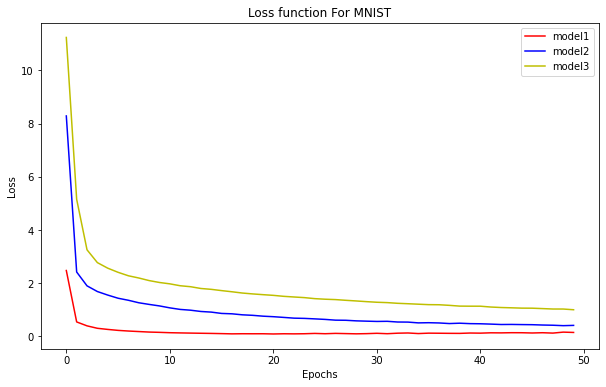

In [86]:
import matplotlib.pyplot as plt
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(train_loss_1), 'r', label='model1')
plt.plot(np.array(train_loss_2), 'b', label='model2')
plt.plot(np.array(train_loss_3), 'y', label='model3')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Loss') 
plt.legend()
plt.title("Loss function For MNIST")
plt.show()



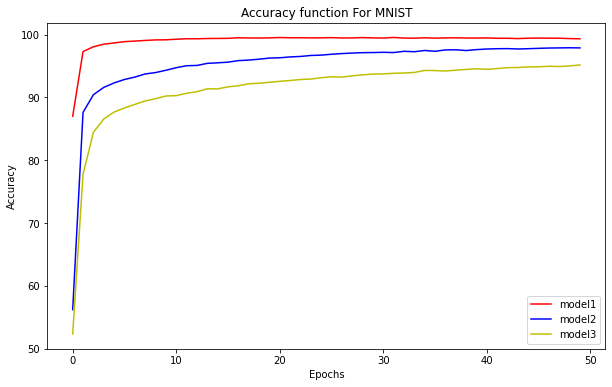

In [87]:
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(accuracy_train_1), 'r', label='model1')
plt.plot(np.array(accuracy_train_2), 'b', label='model2')
plt.plot(np.array(accuracy_train_3), 'y', label='model3')

# naming the x axis
plt.xlabel('Epochs')
# naming the y axis
plt.ylabel('Accuracy') 
plt.legend()
plt.title("Accuracy function For MNIST")
plt.show()